In [1]:
from params import RANDOM_SEED, LocationConfig, CreateDataConfig
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import insightface
import fnmatch
import pickle
import torch
import cv2
import os

In [2]:
LocationConfig.data

'data/BFD/enc/'

In [33]:
for image_path in tqdm(Path('data/DENTA/images_original/').glob('*.jpg')):
    img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
    scale = 640/max(img.shape)
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    filename = str(image_path).split('/')[-1]
    cv2.imwrite(os.path.join(LocationConfig.images,filename), resized)

42it [00:06,  6.29it/s]


In [ ]:
cols = ['VideoName', 'ValueExtraversion','ValueAgreeableness','ValueConscientiousness','ValueNeurotisicm','ValueOpenness']

In [4]:
total_f=0
for image_path in tqdm(Path(LocationConfig.images).glob('*.png')):
    total_f += 1

440it [00:00, 248050.24it/s]


In [5]:
class FaceDetection:
    def __init__(self, use_gpu=True):
        self.use_gpu = use_gpu
        self.image_size = 640
        self.det_thresh = 0.7
        self.detector = self._get_face_detection_model()

    def _get_device_used_code(self):
        if not self.use_gpu:
            return -1
        return 1

    def _get_face_detection_model(self):
        app_kwargs = {'providers': ['CPUExecutionProvider','CUDAExecutionProvider']}
        model_detector_path = 'model/det_10g.onnx'
        detector = insightface.model_zoo.get_model(model_detector_path, **app_kwargs)
        detector.prepare(ctx_id=self._get_device_used_code(), det_thresh=self.det_thresh)#, input_size=(self.image_size, self.image_size))
        return detector

    def detect_face(self, img: np.ndarray) -> np.ndarray:
        """
        Detects a face in an image

        Parameters
        ----------
        img
            Input image with a face
        Returns
        -------
        Bounding box of the original face
        """
        bboxes, _ = self.detector.detect(img)
        return bboxes

In [6]:
def create_new_data_directories():
    Path(LocationConfig.data).mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.data + 'train').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.data + 'test').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.crop_images).mkdir(exist_ok=True, parents=True)
    
create_new_data_directories()

In [7]:
import torchvision.transforms.functional as F
from torchvision import transforms, datasets

class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = 128 #np.max([w, h])
        hp = int((243 - w) / 2) # 243 # 162
        vp = int((311 - h) / 2) # 311 # 216
        padding = (hp, vp, hp, vp)
        return F.pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((311, 243)), #311, 243 #216 x 162
    # transforms.ToTensor(),
    # transforms.Normalize((0.4786, 0.5226, 0.6365), (0.3238, 0.3334, 0.3707)),
])

In [12]:
def detect_and_crop(face_detect_app: FaceDetection, input_path: Path, output_path: str, img_num: int):
    img = cv2.imread(str(input_path))
    faces = face_detect_app.detect_face(img)
    if len(faces) == 0 or len(faces) > 1:
        return

    face_box = faces[0].astype(np.int32)
    width = (face_box[3] - face_box[1]) // 7
    height = (face_box[2] - face_box[0]) // 7
    
    #Chalearn requirements:
    # if width < 8:
    #     return
    # if height < 7:
    #     return
    
    try:
        new_img = img[max(face_box[1]-width, 0) : min(face_box[3]+width, img.shape[0]-1), max(face_box[0]-height, 0) : min(face_box[2]+height, img.shape[1]-1)]

    except IndexError:
        print('ROZMIAR NIE DZIALA')
        return
    if new_img is None:
        return
    new_img = transform(Image.fromarray(new_img))
    new_img = np.array(new_img)
    # new_img = np.transpose(new_img, (2, 1, 0))
    filename = str(input_path).split('/')[-1]
    filename = filename[:-3] + 'png'
    cv2.imwrite(os.path.join(output_path,filename), new_img)

In [13]:
face_detector = FaceDetection()
i=0
for image_path in tqdm(Path(LocationConfig.images).glob('*.jpg'), total=total_f):
    detect_and_crop(face_detector, image_path, LocationConfig.crop_images, i)
    i+=1

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


  0%|          | 0/42 [00:00<?, ?it/s]


AssertionError: 

In [8]:
def create_dataset(images_path, grayscale=False):
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv', index_col=0)
    X_train, X_test = train_test_split(
        np.arange(1,41), #np.array(df.index), 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=3
    )
    print(X_test)
    images_dict_train = {'num':[], 'X':[], 'Y':[]}
    images_dict_test = {'num':[], 'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        X = cv2.imread(str(image_path)) 
        if grayscale:
            X = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
            X = np.expand_dims(X, axis=2)
        Y = df.loc[image_path.name].values
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        img_num = int(image_path.name.split('_')[0])
        if img_num in X_test:
            images_dict_test['num'].append(img_num)
            images_dict_test['X'].append(X)
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['num'].append(img_num)
            images_dict_train['X'].append(X)
            images_dict_train['Y'].append(Y)
            
    with open(LocationConfig.data + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(LocationConfig.data + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_dataset(LocationConfig.crop_images, grayscale=True)

[30 17 10 28]


100%|██████████| 440/440 [00:01<00:00, 269.74it/s]


In [4]:
import face_recognition

def create_enc(images_path):
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv', index_col=0)
    X_train, X_test = train_test_split(
        np.arange(1,41), #np.array(df.index), 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=3
    )
    print(X_test)
    images_dict_train = {'num':[], 'X':[], 'Y':[]}
    images_dict_test = {'num':[], 'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        img = face_recognition.load_image_file(str(image_path))
        face_locations = face_recognition.face_locations(img, model="cnn")
        codes = face_recognition.face_encodings(img, known_face_locations=face_locations, model="large")
        if len(codes) < 1:
            continue
        Y = df.loc[image_path.name].values
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        img_num = int(image_path.name.split('_')[0])
        if img_num in X_test:
            images_dict_test['num'].append(img_num)
            images_dict_test['X'].append(codes[0])
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['num'].append(img_num)
            images_dict_train['X'].append(codes[0])
            images_dict_train['Y'].append(Y)
            
    with open(LocationConfig.data + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(LocationConfig.data + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_enc(LocationConfig.crop_images)

[30 17 10 28]


100%|██████████| 440/440 [52:17<00:00,  7.13s/it]


In [9]:
LocationConfig.data + 'test/'

'data/BFD/gray/test/'

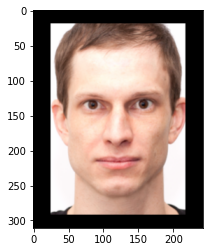

In [49]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook


img = cv2.imread('data/BFD/crop_images/27_Conscientiousness_enhanced.png')
#Show the image with matplotlib
plt.imshow((cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
plt.show()

In [11]:
from params import RANDOM_SEED, LocationConfig, CreateDataConfig
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pathlib import Path
import face_recognition
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import insightface
import fnmatch
import pickle
import torch
import cv2
import os

def create_new_data_directories(path):
    Path(path).mkdir(exist_ok=True, parents=True)
    Path(path + 'train').mkdir(exist_ok=True, parents=True)
    Path(path + 'test').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.crop_images).mkdir(exist_ok=True, parents=True)
    
def get_short_video_name(videoNames):
    ShortVideoName = []
    for videoName in videoNames.values:
        ShortVideoName.append(videoName.split('.')[0])
    return ShortVideoName

def create_mean_video_name_df(df):
    cols = ['ValueExtraversion','ValueAgreeableness','ValueConscientiousness','ValueNeurotisicm','ValueOpenness','ShortVideoName']
    grouped_df = df[cols].groupby('ShortVideoName')
    mean_df = grouped_df.mean()
    mean_df = mean_df.reset_index()
    return mean_df


def create_dataset_ChaLearn(images_path, end_path, grayscale=False):
    create_new_data_directories(end_path)
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv')

    df['ShortVideoName'] = get_short_video_name(df['VideoName'])

    mean_df = create_mean_video_name_df(df)
    mean_df.to_csv(LocationConfig.labels + 'bigfive_labels_mean.csv')
    df = mean_df.set_index('ShortVideoName')
    all_x = np.array(df.index)
    X_train, X_test = train_test_split(
        all_x, 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=1
    )

    images_dict_train = {'X':[], 'Y':[]}
    images_dict_test = {'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        X = cv2.imread(str(image_path)) 
        if grayscale:
            X = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
            X = np.expand_dims(X, axis=2)
        image_group = image_path.name.split('.')[0]
        Y = df.loc[image_group].values
        image_no = image_path.name.split('.')[2][-5:]
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        if image_group in X_test:
            images_dict_test['X'].append(X)
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['X'].append(X)
            images_dict_train['Y'].append(Y)
            
    with open(end_path + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(end_path + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
create_dataset_ChaLearn(LocationConfig.crop_images, end_path=LocationConfig.gray, grayscale=True)

100%|██████████| 28990/28990 [00:27<00:00, 1058.84it/s]


In [11]:
create_dataset_ChaLearn(LocationConfig.crop_images, end_path=LocationConfig.rgb, grayscale=False)

100%|██████████| 28990/28990 [00:32<00:00, 904.08it/s] 


In [12]:
def create_enc_ChaLearn(images_path, end_path):
    create_new_data_directories(end_path)
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv')

    df['ShortVideoName'] = get_short_video_name(df['VideoName'])

    mean_df = create_mean_video_name_df(df)
    mean_df.to_csv(LocationConfig.labels + 'bigfive_labels_mean.csv')
    df = mean_df.set_index('ShortVideoName')
    all_x = np.array(df.index)
    X_train, X_test = train_test_split(
        all_x, 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=1
    )

    images_dict_train = {'X':[], 'Y':[]}
    images_dict_test = {'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        img = face_recognition.load_image_file(str(image_path))
        face_locations = face_recognition.face_locations(img, model="cnn")
        codes = face_recognition.face_encodings(img, known_face_locations=face_locations, model="large")
        if len(codes) < 1:
            continue
        image_group = image_path.name.split('.')[0]
        Y = df.loc[image_group].values
        image_no = image_path.name.split('.')[2][-5:]
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        if image_group in X_test:
            images_dict_test['X'].append(codes[0])
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['X'].append(codes[0])
            images_dict_train['Y'].append(Y)
            
    with open(end_path + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(end_path + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
create_enc_ChaLearn(LocationConfig.crop_images, LocationConfig.enc)

# Create My Data

In [5]:
def create_dataset(grayscale=False, data_type='BFD'):
    images_path = f'data/DENTA/{data_type}/crop_images/'
    df = pd.read_csv('data/DENTA/bigfive_labels.csv', index_col=0)
    images_dict_test = {'num':[], 'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        X = cv2.imread(str(image_path)) 
        if grayscale:
            X = cv2.cvtColor(X, cv2.COLOR_BGR2GRAY)
            X = np.expand_dims(X, axis=2)
        Y = df.loc[image_path.name.split('.')[0]].values
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        images_dict_test['num'].append(image_path.name.split('.')[0])
        images_dict_test['X'].append(X)
        images_dict_test['Y'].append(Y)
    data_color = 'gray' if grayscale else 'rgb'
    with open(f'data/DENTA/{data_type}/{data_color}/test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_dataset(grayscale=False, data_type='BFD')
create_dataset(grayscale=True, data_type='BFD')
create_dataset(grayscale=False, data_type='ChaLearn')
create_dataset(grayscale=True, data_type='ChaLearn')

100%|██████████| 41/41 [00:00<00:00, 303.05it/s]


In [7]:
import face_recognition

def create_enc(data_type='BFD'):
    images_path = f'data/DENTA/{data_type}/crop_images/'
    df = pd.read_csv('data/DENTA/bigfive_labels.csv', index_col=0)
    images_dict_test = {'num':[], 'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        img = face_recognition.load_image_file(str(image_path))
        face_locations = face_recognition.face_locations(img, model="cnn")
        codes = face_recognition.face_encodings(img, known_face_locations=face_locations, model="large")
        if len(codes) < 1:
            continue
        Y = df.loc[image_path.name.split('.')[0]].values
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        images_dict_test['num'].append(image_path.name.split('.')[0])
        images_dict_test['X'].append(codes[0])
        images_dict_test['Y'].append(Y)
            
    with open(f'data/DENTA/{data_type}/enc/test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_enc(data_type='BFD')
create_enc(data_type='ChaLearn')

100%|██████████| 41/41 [01:20<00:00,  1.95s/it]
